# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **END-TO-END MACHINE LEARNING PROJECT EXERCISES**

---

## **PREPRARE DATA FOR MACHINE LEARNING:**

### **1. SETUP:**

In [1]:
# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [2]:
# Common libraries.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Default settings for matplotlib.
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

In [3]:
# Create a directory for matplotlib images.
from pathlib import Path

IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)

### **2. DOWNLOAD THE DATA:**

In [4]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("data/housing.tgz")
    if not tarball_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="data")
    return pd.read_csv(Path("data/housing.csv"))

housing = load_housing_data()

### **3. SPLIT INTO A TRAIN/TEST:**

In [5]:
from sklearn.model_selection import train_test_split

housing["income_cat"] = pd.cut(
    housing["median_income"], 
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Single stratified split.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

# We can drop income category now.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)  # type: ignore

### **4. PREPRARE TRANSFORMATION PIPELINE:**

In [6]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
    
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
    
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

In [7]:
# Final preprocessing.
from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer([
    ("bedrooms_per_rooms", ratio_pipeline(), ("total_bedrooms", "total_rooms")),
    ("rooms_per_house", ratio_pipeline(), ("total_rooms", "households")),
    ("people_per_house", ratio_pipeline(), ("population", "households")),
    ("log_attrs", log_pipeline, ("total_bedrooms", "total_rooms", "population",
                                 "households", "median_income")),
    ("geo_attrs", cluster_simil, ("latitude", "longitude")),
    ("cat_attrs", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)  # type: ignore | One column remaining: housing_median_age.

In [8]:
# We want to predict median house value.
train_set = strat_train_set.drop("median_house_value", axis=1)  # type: ignore
train_labels = strat_train_set["median_house_value"].copy()  # type: ignore

---

## **EXERCISE 01:**

Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

param_grid = [
    {
        "svr__kernel": ["linear"],
        "svr__C": [10., 30., 100., 300., 1000., 3000., 10000., 30000.]
    },
    {
        "svr__kernel": ["rbf"],
        "svr__C": [10., 30., 100., 300., 1000.],
        "svr__gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
    },
]

svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR())
])

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(train_set.iloc[:5000], train_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_per_rooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_na...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001FC80489D80>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [10]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

68861.45894915906

In [11]:
grid_search.best_params_

{'svr__C': 30000.0, 'svr__kernel': 'linear'}

---

## **EXERCISE 02:**

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_rnd = {  # gamma is ignored when kernel is "linear"
    "svr__kernel": ["linear", "rbf"],
    "svr__C": reciprocal(20, 200_000),
    "svr__gamma": expon(scale=1.),
}

rnd_search = RandomizedSearchCV(
    svr_pipeline,
    param_distributions=param_rnd,
    n_iter=50,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

rnd_search.fit(train_set.iloc[:5000], train_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms_per_rooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feat...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001FC80489D80>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FC8048A3E0>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FC80996EC0>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [13]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

56076.66084392369

In [14]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [15]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # 100 000 samples.
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

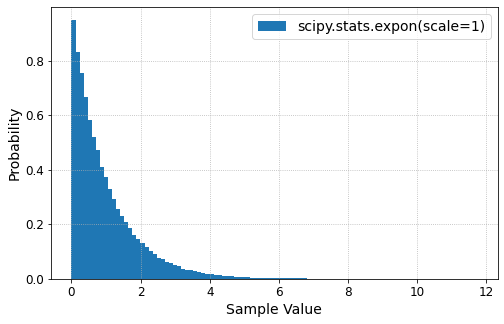

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(s, bins=100, density=True, label="scipy.stats.expon(scale=1)")
plt.xlabel("Sample Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.legend()
plt.show()

We used the `reciprocal()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

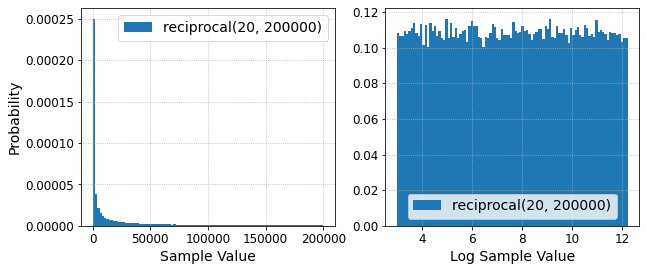

In [17]:
np.random.seed(42)

s = reciprocal(20, 200_000).rvs(100_000)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(s, bins=100, density=True, label="reciprocal(20, 200000)")
plt.xlabel("Sample Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.log(s), bins=100, density=True, label="reciprocal(20, 200000)")
plt.xlabel("Log Sample Value")
plt.grid(linestyle="dotted")
plt.legend(loc="lower center")
plt.show()

---

## **EXERCISE 03:**

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

selector_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("selector", SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.01)),  # Min feature importance.
    ("svr", SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"]))
])

In [19]:
from sklearn.model_selection import cross_val_score

selector_rmses = -cross_val_score(
    selector_pipeline,
    train_set.iloc[:5000],
    train_labels.iloc[:5000],
    scoring="neg_root_mean_squared_error",
    cv=3
)
pd.Series(selector_rmses).describe()

count        3.000000
mean     56113.906024
std       1967.896593
min      54427.643101
25%      55032.794045
50%      55637.944990
75%      56957.037486
max      58276.129982
dtype: float64

---

## **EXERCISE 04:**

Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, BaseEstimator, TransformerMixin
from sklearn.base import clone, check_is_fitted

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)  # type: ignore
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_  # type: ignore
        if hasattr(self.estimator, "feature_names_in"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)  # type: ignore
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions
    
    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}" for i in range(n_outputs)]
    

In [27]:
# Ensure that complies to scikit-learn api.
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

In [29]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = train_set[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, train_labels)

array([[ 68850.],
       [279600.],
       [ 79000.],
       ...,
       [135700.],
       [258100.],
       [ 62700.]])

In [30]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

In [37]:
# Include the new transformer instead of the cluster similarity.
transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo_attrs")
transformers[geo_index] = ("geo_attrs", knn_transformer, ["latitude", "longitude"])
new_geo_preprocessing = ColumnTransformer(transformers)

In [38]:
new_geo_pipeline = Pipeline([
    ("preprocessing", new_geo_preprocessing),
    ("svr", SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"]))
])

In [42]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  train_set.iloc[:5000],
                                  train_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     104487.511247
std        2940.605612
min      101582.902572
25%      102999.847802
50%      104416.793032
75%      105939.815585
max      107462.838138
dtype: float64

## **EXERCISE 05:**

Exercise: _Automatically explore some preparation options using `RandomSearchCV`._

In [43]:
param_distribs = {
    "preprocessing__geo_attrs__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo_attrs__estimator__weights": ["distance", "uniform"],
    "svr__C": reciprocal(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring="neg_root_mean_squared_error",
                                        random_state=42)
new_geo_rnd_search.fit(train_set.iloc[:5000], train_labels.iloc[:5000])
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

106367.27307218559

## **EXERCISE 06:**

Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise._

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        if self.with_mean:
            return X + self.mean_
        return X + self.mean_
    
    def get_feature_names_out(self, input_features=None):
        if not input_features:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        if len(input_features) != self.n_features_in_:
            raise ValueError("Invalid number of features")
        if hasattr(self, "feature_names_in_") and not np.all(
            self.feature_names_in_ == input_features
        ):
            raise ValueError("input_features ≠ feature_names_in_")
        return input_features
        

In [88]:
check_estimator(StandardScalerClone())

In [89]:
np.random.seed(42)
X = np.random.rand(100, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

In [90]:
scaler = StandardScalerClone(with_mean=False)
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, X / X.std(axis=0))

In [91]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

In [92]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

In [93]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])